# Python Interactive Example: TinyMPC on Quadrotor (Extended Version)
In this demonstration, we showcase an interactive Python workflow using TinyMPC. You can generate C++ code and engage with it seamlessly within the Python environment. This example guides you through the entire workflow, beginning with the quadrotor's nonlinear dynamics. The process closely mirrors the steps taken for deploying MPC on the Crazyflie.

If any issues arise, restart the kernel.

Load necessary packages, make sure to install `tinympc` ([README.md](../README.md))

In [1]:
import tinympc
import math
%matplotlib inline
import matplotlib.pyplot as plt

## Quadrotor Dynamics
Build the quadrotor nonlinear dynamics and linearize around the hovering state using `autograd`. 

In [2]:
import autograd.numpy as np
import autograd.numpy as sqrt
from autograd.numpy.linalg import norm
from autograd.numpy.linalg import inv
from autograd import jacobian
from autograd.test_util import check_grads
np.set_printoptions(precision=3, suppress=True)

# autograd does not work with np.block

#Quaternion stuff, check `Planning with Attitude` paper for more details
def hat(v):
    return np.array([[0, -v[2], v[1]],
                     [v[2], 0, -v[0]],
                     [-v[1], v[0], 0.0]])

def L(q):
    s = q[0]
    v = q[1:4]
    up = np.hstack([s, -v])
    down = np.hstack([v.reshape(3,1), s*np.eye(3) + hat(v)])
    L = np.vstack([up,down])
    return L

T = np.diag([1.0, -1, -1, -1])
H = np.vstack([np.zeros((1,3)), np.eye(3)])

def qtoQ(q):
    return H.T @ T @ L(q) @ T @ L(q) @ H

def G(q):
    return L(q) @ H

def rptoq(phi):
    return (1./sqrt(1+phi.T @ phi)) * np.hstack([1, phi])

def qtorp(q):
    return q[1:4]/q[0]

def E(q):
    up = np.hstack([np.eye(3), np.zeros((3,3)), np.zeros((3,6))])
    mid = np.hstack([np.zeros((4,3)), G(q), np.zeros((4,6))])
    down = np.hstack([np.zeros((6,3)), np.zeros((6,3)), np.eye(6)])
    E = np.vstack([up, mid, down])
    return E

# Quadrotor parameters
mass = 0.035  # mass
J = np.array([[1.66e-5, 0.83e-6, 0.72e-6], [0.83e-6, 1.66e-5, 1.8e-6], [0.72e-6, 1.8e-6, 2.93e-5]])  # inertia
g = 9.81  # gravity
# thrustToTorque = 0.005964552
thrustToTorque = 0.0008  # thrust to torque ratio
el = 0.046/1.414213562  # arm length
scale = 65535  # PWM scale
kt = 2.245365e-6*scale # thrust coefficient, u is PWM in range [0...1], 0 is no thrust, 1 is max thrust
km = kt*thrustToTorque # moment coefficient

freq = 50.0 # >>>>>>>> CONTROL FREQUENCY <<<<<<<<<<
h = 1/freq #50 Hz 

Nx1 = 13        # number of states (quaternion)
Nx = 12         # number of states (linearized): x, y, z, Rodriguez 3-parameters (p, q, r), vx, vy, vz, wx, wy, wz
Nu = 4          # number of controls (motor pwm signals, 0-1)

In [3]:
# Quadrotor dynamics -- single rigid body dynamics
def quad_dynamics(x, u):
    r = x[0:3]  # position
    q = x[3:7]/norm(x[3:7])  # normalize quaternion
    v = x[7:10]  # linear velocity
    omg = x[10:13]  # angular velocity
    Q = qtoQ(q)  # quaternion to rotation matrix

    dr = v
    dq = 0.5*L(q)@H@omg
    dv = np.array([0, 0, -g]) + (1/mass)*Q@np.array([[0, 0, 0, 0], [0, 0, 0, 0], [kt, kt, kt, kt]])@u
    domg = inv(J)@(-hat(omg)@J@omg + np.array([[-el*kt, -el*kt, el*kt, el*kt], [-el*kt, el*kt, el*kt, -el*kt], [-km, km, -km, km]])@u)
    
    return np.hstack([dr, dq, dv, domg])

# RK4 integration with zero-order hold on u
def quad_dynamics_rk4(x, u):
    f1 = quad_dynamics(x, u)
    f2 = quad_dynamics(x + 0.5*h*f1, u)
    f3 = quad_dynamics(x + 0.5*h*f2, u)
    f4 = quad_dynamics(x + h*f3, u)
    xn = x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
    xnormalized = xn[3:7]/norm(xn[3:7])  # normalize quaternion
    return np.hstack([xn[0:3], xnormalized, xn[7:13]])

# Linearize the dynamics around x0, u0
A_jac = jacobian(quad_dynamics_rk4, 0)  # jacobian wrt x
B_jac = jacobian(quad_dynamics_rk4, 1)  # jacobian wrt u

# Hovering state and control input
rg = np.array([0.0, 0, 0.0])
qg = np.array([1.0, 0, 0, 0])
vg = np.zeros(3)
omgg = np.zeros(3)
x0 = np.hstack([rg, qg, vg, omgg])
u0 = (mass*g/kt/4)*np.ones(4)  # ~each motor thrust to compensate for gravity
print(x0, u0)

check_grads(quad_dynamics_rk4, modes=['rev'], order=2)(x0, u0)

Anp1 = A_jac(x0, u0)  # jacobian of the dynamics wrt x at x0, u0
Bnp1 = B_jac(x0, u0)  # jacobian of the dynamics wrt u at x0, u0

# `Planning with Attitude` trick, attitude Jacobians
Anp = E(qg).T @ Anp1 @ E(qg) 
Bnp = E(qg).T @ Bnp1
print("A = \n", Anp)
print("B = \n", Bnp)

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0.583 0.583 0.583 0.583]
A = 
 [[ 1.     0.     0.     0.     0.004  0.     0.02   0.     0.     0.
   0.     0.   ]
 [ 0.     1.     0.    -0.004  0.     0.     0.     0.02   0.    -0.
   0.     0.   ]
 [ 0.     0.     1.     0.     0.     0.     0.     0.     0.02   0.
   0.     0.   ]
 [ 0.     0.     0.     1.     0.     0.     0.     0.     0.     0.01
   0.     0.   ]
 [ 0.     0.     0.     0.     1.     0.     0.     0.     0.     0.
   0.01   0.   ]
 [ 0.     0.     0.     0.     0.     1.     0.     0.     0.     0.
   0.     0.01 ]
 [ 0.     0.     0.     0.     0.392  0.     1.     0.     0.     0.
   0.002  0.   ]
 [ 0.     0.     0.    -0.392  0.     0.     0.     1.     0.    -0.002
   0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     1.     0.
   0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     1.
   0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0. 

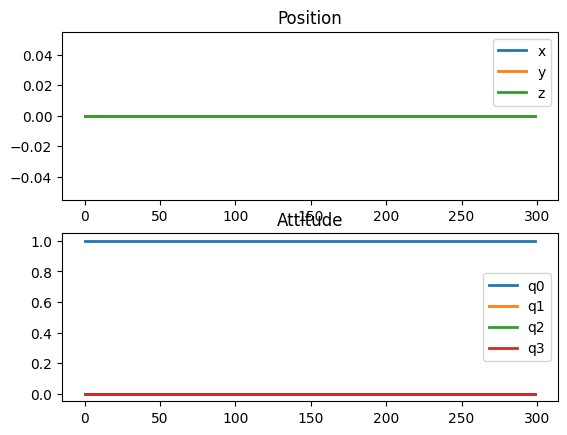

In [4]:
# function to visualize the trajectory
def visualize_trajectory(x_all):
    # Set up the figure and axis for plotting
    fig, ax = plt.subplots(2, 1)

    # Plot the trajectory
    x_all = np.array(x_all)
    nsteps = len(x_all)
    steps = np.arange(nsteps)
    ax[0].plot(steps, x_all[:, 0], label="x", linewidth=2)
    ax[0].plot(steps, x_all[:, 1], label="y", linewidth=2)
    ax[0].plot(steps, x_all[:, 2], label="z", linewidth=2)
    ax[0].legend()
    ax[0].title.set_text("Position")

    ax[1].plot(steps, x_all[:, 3], label="q0", linewidth=2)
    ax[1].plot(steps, x_all[:, 4], label="q1", linewidth=2)
    ax[1].plot(steps, x_all[:, 5], label="q2", linewidth=2)
    ax[1].plot(steps, x_all[:, 6], label="q3", linewidth=2)
    ax[1].legend()
    ax[1].title.set_text("Attitude")
    plt.show()

x_all = []
# simulate the dynamics with the zero controller
x = x0
for i in range(300):
    x = quad_dynamics_rk4(x, u0)
    x_all.append(x)

visualize_trajectory(x_all)

## LQR Controller

Let's run LQR on the linearized model

K = 
 [[-0.222  0.213  0.4   -0.631 -0.717 -1.266 -0.133  0.124  0.232 -0.046
  -0.059 -0.342]
 [ 0.213  0.188  0.4   -0.48   0.687  1.292  0.127  0.104  0.232 -0.026
   0.056  0.345]
 [ 0.182 -0.197  0.4    0.512  0.418 -1.352  0.098 -0.11   0.232  0.028
   0.015 -0.351]
 [-0.174 -0.204  0.4    0.6   -0.388  1.326 -0.093 -0.118  0.232  0.043
  -0.013  0.348]]


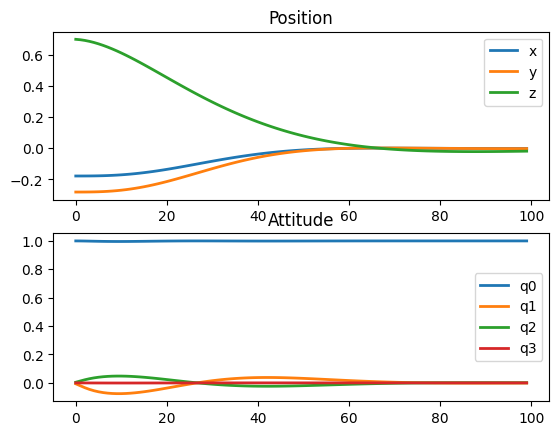

In [5]:
# Choose Q and R matrices based on Bryson's rule 
max_dev_x = np.array([0.1, 0.1, 0.1,  0.5, 0.5, 0.03,  0.5, 0.5, 0.5,  0.7, 0.7, 0.2])
max_dev_u = np.array([0.5, 0.5, 0.5, 0.5])/6
Q = np.diag(1./max_dev_x**2)
R = np.diag(1./max_dev_u**2)
# print("Q = \n", Q)
# print("R = \n", R)

# Riccati recursion on the linearized dynamics
P = Q
for i in range(100):
    P = Q + Anp.T @ P @ Anp - Anp.T @ P @ Bnp @ inv(R + Bnp.T @ P @ Bnp) @ Bnp.T @ P @ Anp
    # print(P)
    K = inv(R + Bnp.T @ P @ Bnp) @ Bnp.T @ P @ Anp
print("K = \n", K)

# Drive the system from initial state to the hovering state using the LQR controller:
# LQR controller, input is 13x1 state vector
def lqr_controller(x):
    q = x[3:7]
    phi = qtorp(L(qg).T @ q)
    delta_x = np.hstack([x[0:3]-rg, phi, x[7:10]-vg, x[10:13]-omgg])
    return -K @ delta_x + u0

x = x0
x[0:3] = rg + 1*np.random.randn(3)/3  # disturbed initial position
NSIM = 100
x_all = []
# simulate the dynamics with the LQR controller
for i in range(NSIM):
    u = lqr_controller(x)
    x = quad_dynamics_rk4(x, u)
    x_all.append(x)

visualize_trajectory(x_all)

## Code Generation

We are done with the dynamics and LQR controller. Now, let's define the class and compile original TinyMPC code to get a generic shared/dynamic library

**PLEASE CHANGE `tinympc_python_dir` TO YOUR ABSOLUTE PATH**

In [6]:
prob = tinympc.TinyMPC()

tinympc_python_dir = "/home/khai/SSD/Code/tinympc-python"  # Your absolute path to the tinympc-python directory, you may only need to change this

tinympc_dir = tinympc_python_dir + "/tinympc/TinyMPC"  # Path to the TinyMPC directory (C code)
prob.compile_lib(tinympc_dir)  # Compile the library (or use the binary provided)

True

Load the generic shared/dynamic library. **You may want to change the extension of the library based on your OS -- Linux: .so, Mac: .dylib, Windows: .dll**

In [7]:
os_ext = ".so"  # CHANGE THIS BASED ON YOUR OS
lib_dir = tinympc_dir + "/build/src/tinympc/libtinympcShared" + os_ext  # Path to the compiled library
prob.load_lib(lib_dir)  # Load the library

Here we setup problem data and settings for TinyMPC

In [8]:
n = 12  # number of states == Nx
m = 4   # number of inputs == Nu
N = 10  # horizon length

A = Anp.transpose().reshape((n * n)).tolist() # col-major order list
B = Bnp.transpose().reshape((n * m)).tolist() # col-major order list
Q = (1./max_dev_x**2).tolist()  # diagonal of state cost
R = (1./max_dev_u**2).tolist()  # diagonal of input cost
rho = 0.1  # ADMM penalty parameter

x_min = [-1000.0] * n * N           # state constraints 
x_max = [1000.] * n * N             # state constraints
u_min = [-u0[0]] * m * (N - 1)      # input constraints
u_max = [1.0-u0[0]] * m * (N - 1)   # input constraints

abs_pri_tol = 1.0e-3    # absolute primal tolerance
abs_dual_tol = 1.0e-3   # absolute dual tolerance
max_iter = 100          # maximum number of iterations
check_termination = 1   # whether to check termination and period

# Setup problem data
prob.setup(n, m, N, A, B, Q, R, x_min, x_max, u_min, u_max, rho, abs_pri_tol, abs_dual_tol, max_iter, check_termination)

True

After define the problem, we generate the tailored code with above data. 

**Here we compile it for interactive Python script but you can use it directly for your applications/systems**

In [15]:
output_dir = tinympc_python_dir + "/generated_code"  # Path to the generated code
prob.tiny_codegen(tinympc_dir, output_dir)  
# You may want to check if Kinf in generated_code follows the same pattern as previous K in LQR, otherwise something is wrong
prob.compile_lib(output_dir)

True

## Interactive MPC

Run the interactive MPC example which calls the generated code, use nonlinear dynamics for simulation

Since this works with pointers, underlying data is persistent in each kernel session (something like deepcopy/shallowcopy or pass by reference/value). If you want to run from the original setup, you may need to change data back or 
restart kernel.

### Quadrotor Hovering

=== START INTERACTIVE MPC ===
100


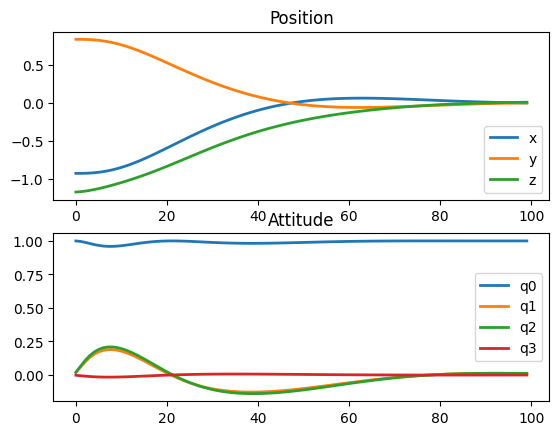

In [10]:
x_all = []  # List of all stored states

def mpc_tasks():
    solver = tinympc.TinyMPC()
    solver.setup(n, m, N, A, B, Q, R, x_min, x_max, u_min, u_max, rho, abs_pri_tol, abs_dual_tol, max_iter, check_termination)
    solver.load_lib(output_dir + "/build/tinympc/libtinympcShared" + os_ext)  # Load the library
    
    # This function is similar in firmware
    def mpc_controller(x):
        # input is 13d state vector
        q = x[3:7]
        phi = qtorp(L(qg).T @ q)
        delta_x = np.hstack([x[0:3]-rg, phi, x[7:10]-vg, x[10:13]-omgg]) # 12d state vector
        noise = np.random.normal(0, 0.01, (n,))*0
        delta_x_noise = (delta_x + noise).reshape(n).tolist()

        # 1. Set initial state from measurement    
        solver.set_x0(delta_x_noise, 0)  # Set initial state to C code

        # 2. Set the reference state if needed
        # At step 200, set x = 1
        # if (i == 200):
        #     solver.set_xref(delta_xref_next, 0)  # Set the reference state to C code

        # 3. Solve the problem
        solver.solve(0)  # Call the solve in C code

        # 4. Get the control input
        solver.get_u(uhrz, 0)  # Get the control input from C code

        return np.array(uhrz[0:4]) + u0
    
    x = x0  # initial state
    x[0:3] = rg + np.random.randn(3)  # initial position
    xhrz = [0.0] * n * N  # List of states in horizon
    uhrz = [0.0] * m * (N - 1)  # List of control inputs in horizon

    print("=== START INTERACTIVE MPC ===")

    NSIM = 100
    for i in range(NSIM):
        # Get the control input
        u_current = mpc_controller(x)
        
        # Simulate the dynamics
        x = quad_dynamics_rk4(x, u_current)

        x = x.reshape(n+1).tolist()
        x_all.append(x)

    print(len(x_all))

mpc_tasks()
visualize_trajectory(x_all)

### Quadrotor Tracking

Quadroter hovering task is done. Let's try trajectory tracking! Remember that the original reference is a 13-state trajectory. Since we linearized about hovering, the correct reference for MPC is a 12-state trajectory, relative to the hovering state. Let's do a figure-8.
We don't use input reference for now.

In [20]:
# Generate reference trajectory
Tfinal = 10.0
Nt = int(Tfinal/h)+1
Xref = np.array([[1*math.cos(t)*math.sin(t), 1*math.cos(t), 0.5, 1., 0.0, 0.0, 0, 0, 0, 0, 0, 0, 0] for t in np.linspace(-math.pi/2, 3*math.pi/2, Nt)])
xref = [np.zeros(n) for i in range(Nt)]

for k in range(Nt):
    x_ = Xref[k]
    q_ = x_[3:7]
    phi_ = qtorp(L(qg).T @ q_)
    xref[k] = np.hstack([x_[0:3]-rg, phi_, x_[7:10]-vg, x_[10:13]-omgg])

=== START INTERACTIVE MPC ===
491


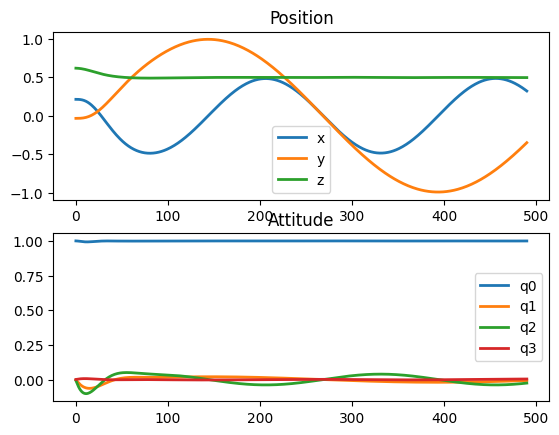

In [22]:
x_all = []  # List of all stored states

def mpc_tasks():
    solver = tinympc.TinyMPC()
    solver.setup(n, m, N, A, B, Q, R, x_min, x_max, u_min, u_max, rho, abs_pri_tol, abs_dual_tol, max_iter, check_termination)
    solver.load_lib(output_dir + "/build/tinympc/libtinympcShared" + os_ext)  # Load the library
    
    # This function is similar in firmware
    def mpc_controller(x, xref):
        # input is 13d state vector
        q = x[3:7]
        phi = qtorp(L(qg).T @ q)
        delta_x = np.hstack([x[0:3]-rg, phi, x[7:10]-vg, x[10:13]-omgg]) # 12d state vector
        noise = np.random.normal(0, 0.01, (n,))*0
        delta_x_noise = (delta_x + noise).reshape(n).tolist()

        # 1. Set initial state from measurement    
        solver.set_x0(delta_x_noise, 0)  # Set initial state to C code

        # 2. Set the reference state if needed
        xref_ = np.array(xref).reshape(n*N).tolist()  # col-major order list
        # print(xref_)
        solver.set_xref(xref_, 0)  # Set the reference state to C code

        # 3. Solve the problem
        solver.solve(0)  # Call the solve in C code

        # 4. Get the control input
        solver.get_u(uhrz, 0)  # Get the control input from C code

        return np.array(uhrz[0:4]) + u0
    
    x = Xref[0]  # initial state
    x[0:3] = Xref[0,0:3] + np.random.randn(3)/10  # initial position
    xhrz = [0.0] * n * N  # List of states in horizon
    uhrz = [0.0] * m * (N - 1)  # List of control inputs in horizon

    print("=== START INTERACTIVE MPC ===")

    NSIM = Nt - N
    for i in range(NSIM):
        # Get the control input
        u_current = mpc_controller(x, xref[i:i+N])
        
        # Simulate the dynamics
        x = quad_dynamics_rk4(x, u_current)

        x = x.reshape(n+1).tolist()
        x_all.append(x)

    print(len(x_all))

mpc_tasks()
visualize_trajectory(x_all)

The actual trajectory is slower than the reference because we only gave it position trajectory to track (dynamically infeasible), you can also provide velocity trajectory via finite difference from the positions.

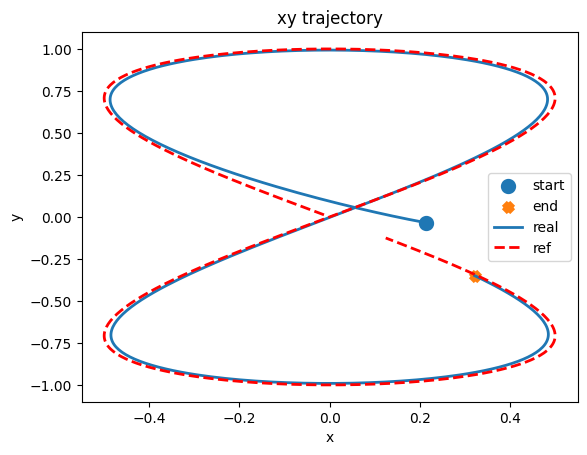

In [23]:
# visualize xy trajectory
x_all = np.array(x_all)
plt.scatter(x_all[0, 0], x_all[0, 1], label="xy", marker="o", linewidth=5)
plt.scatter(x_all[-1, 0], x_all[-1, 1], label="xy", marker="x", linewidth=5)
plt.plot(x_all[:, 0], x_all[:, 1], label="xy", linewidth=2)
plt.plot(Xref[1:Nt - N, 0], Xref[1:Nt - N, 1], label="xy", linewidth=2, linestyle='dashed', color='red')
plt.legend(["start", "end", "real", "ref"])
plt.xlabel("x")
plt.ylabel("y")
plt.title("xy trajectory")
plt.show()

## Deployment

OK, everything works well. Let's see how to use the generated code for deployment. We can export the reference to C code for future use.

In [14]:
# Export a vector of vectors to C header
def export_vec_of_vec_to_c(filename, var_type, var_name, data):
    size = len(data)*len(data[0])
    declare = var_type + " " + var_name + "[" + str(size) + "]"
    def_ = declare + " = {\n"
    for i in range(len(data)):
        def_ = def_ + "  "
        for j in range(len(data[0])):
            def_ = def_ + str(data[i][j])
            if j < len(data[0]) - 1:
                def_ = def_ + ","
        if i < len(data) - 1:
            def_ = def_ + ",\n"
    def_ = def_ + "};\n"

    with open(filename + ".hpp", "a") as f:
        f.write(def_)

export_vec_of_vec_to_c("ref_fig8", "tinytype", "Xref_data", xref)

Post testing the MPC procedure with the generated code, the next step involves deploying it for your specific applications/systems.
The workflow for deployment is tailored to your specific needs, and we aim to provide clear guidance.

Your `tiny_main` may look like this

```C
#include "ref_fig8.hpp"

int main()
{
    int exitflag = 1;
    TinyWorkspace* work = tiny_data_solver.work;
    tiny_data_solver.work->Xref = tiny_MatrixNxNh::Zero();
    tiny_data_solver.work->Uref = tiny_MatrixNuNhm1::Zero();
    tiny_data_solver.settings->max_iter = 150;
    tiny_data_solver.settings->en_input_bound = 1;
    tiny_data_solver.settings->en_state_bound = 1;

    // Map data from trajectory_data
    Matrix<tinytype, NSTATES, NTOTAL> Xref_total = Eigen::Map<Matrix<tinytype, NSTATES, NTOTAL>>(Xref_data);
    work.Xref = Xref_total.block<NSTATES, NHORIZON>(0, 0);

    tiny_VectorNx x0, x1; // current and next simulation states
    x0 = work.Xref.col(0);  // Initial state

    int i = 0;
    for (int k = 0; k < 300; ++k)
    {
        printf("tracking error at step %2d: %.4f\n", k, (x0 - work->Xref.col(1)).norm());

        // 1. Update measurement (use your API to get measurement)
        work->x.col(0) = x0;

        // 2. Update reference (if needed)
        work.Xref = Xref_total.block<NSTATES, NHORIZON>(0, k);

        // 3. Reset dual variables (if needed)
        // work->y = tiny_MatrixNuNhm1::Zero();
        // work->g = tiny_MatrixNxNh::Zero();

        // 4. Solve MPC problem
        exitflag = tiny_solve(&tiny_data_solver);

        // if (exitflag == 0)
        // 	printf("HOORAY! Solved with no error!\n");
        // else
        // 	printf("OOPS! Something went wrong!\n");
        // 	// break;

        std::cout << work->iter << std::endl;
        std::cout << work->u.col(0).transpose().format(CleanFmt) << std::endl;

        // 5. Simulate forward/or use API to send control signal to your real system
        // work->u.col(0) = -tiny_data_solver.cache->Kinf * (x0 - work->Xref.col(0));  // if use LQR only
        x1 = work->Adyn * x0 + work->Bdyn * work->u.col(0);
        x0 = x1;
        // std::cout << x0.transpose().format(CleanFmt) << std::endl;
    }
}
```